In [64]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from chainer import cuda, Variable, FunctionSet, optimizers
import chainer.functions as F
import sys
import csv
from pprint import pprint 

plt.style.use('ggplot')

In [65]:
# 確率的勾配降下法におけるミニバッチ数
batchsize = 30

# 学習の繰り返し回数
n_epoch = 30

# 中間層の数
n_units = 20


#=================================================
# csvファイルからデータを取り出し、listに格納
def set_data():

        filename = "../../../data/secondary_selection/input_data2"
        
        f = open('%s.csv' % filename, 'rU')
        data = csv.reader(f)

        data_set = []
        target_set = []
        for line in data:
                data_set.append(line[1:16])
                target_set.append(line[16])
        f.close()
        np_dataSet = np.array(data_set, dtype=np.float32)
        np_targetSet = np.array(target_set, dtype=np.int32)
        return np_dataSet, np_targetSet

#=================================================

data, target = set_data()

# <!--- start_debug
#print data.shape
#print target.shape
#       end_debug ----> 


# 学習用データをN個、検証用データを残りの個数と設定
# Nの値は暫定的なもの
N = 1200
x_train, x_test = np.split( data, [N])  
y_train, y_test = np.split( target, [N]) 
N_test = y_test.size
#print data
#print target



In [66]:
# 多層パーセプトロンモデルの設定
# 入力 15次元、出力 2次元
model = FunctionSet(l1=F.Linear(15, n_units),
                    l2=F.Linear(n_units, n_units),
                    l3=F.Linear(n_units, n_units),
                    l4=F.Linear(n_units, 2))

# Neural net architecture
# ニューラルネットの構造
def forward(x_data, y_data, train=True ):
        x, t = Variable(x_data), Variable(y_data)
        h1 = F.dropout(F.relu(model.l1(x)), ratio=.2, train=train)
        h2 = F.dropout(F.relu(model.l2(h1)), ratio=.2, train=train)
        h3 = F.dropout(F.relu(model.l3(h2)), ratio=.2, train=train)
        y = model.l4(h3)
        # 0/1の2クラス分類なので誤差関数として、ソフトマックス関数
        # を用いて、誤差を導出
        return F.softmax_cross_entropy(y, t), F.accuracy(y, t)



In [67]:
# Setup optimizer
optimizer = optimizers.Adam()
optimizer.setup(model)

train_loss = []
train_acc= []
test_loss = []
test_acc = []

l1_W = []
l2_W = []
l3_W = []
l4_W = []



epoch 1
train mean loss=0.966889714077, accuracy=0.573333338276
test  mean loss=0.248767334223, accuracy=0.836666667461
epoch 2
train mean loss=0.324216367677, accuracy=0.857499994338
test  mean loss=0.210034042597, accuracy=0.909999990463
epoch 3
train mean loss=0.250869371556, accuracy=0.879999990761
test  mean loss=0.191161991656, accuracy=0.946666646004
epoch 4
train mean loss=0.244282766804, accuracy=0.869166655838
test  mean loss=0.180912204832, accuracy=0.969999980927
epoch 5
train mean loss=0.204888471961, accuracy=0.909999993443
test  mean loss=0.167110464722, accuracy=0.976666659117
epoch 6
train mean loss=0.173197132535, accuracy=0.9183333233
test  mean loss=0.139757798612, accuracy=0.983333319426
epoch 7
train mean loss=0.174297554977, accuracy=0.91833331883
test  mean loss=0.130237099156, accuracy=0.969999986887
epoch 8
train mean loss=0.150127111655, accuracy=0.927499988675
test  mean loss=0.110683872551, accuracy=0.989999991655
epoch 9
train mean loss=0.142655120883, acc

[]

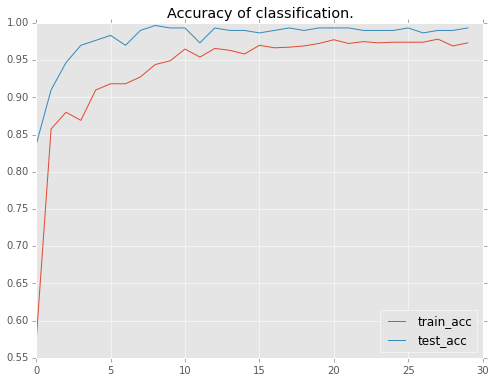

In [68]:
# Learning loop
for epoch in xrange(1, n_epoch+1):
        print 'epoch', epoch

        # training
        # N個の順番をランダムに並び替える
        perm = np.random.permutation(N)
        sum_accuracy = 0
        sum_loss = 0
        # 0〜Nまでのデータをバッチサイズごとに使って学習
        for i in xrange(0, N, batchsize):
                x_batch = x_train[perm[i:i+batchsize]]
                y_batch = y_train[perm[i:i+batchsize]]

                # 勾配を初期化
                optimizer.zero_grads()
                # 順伝播させて誤差と精度を算出
                loss, acc = forward(x_batch, y_batch)
               
                # 誤差逆伝播で勾配を計算
                loss.backward()
                optimizer.update()
                
                sum_loss += float(cuda.to_cpu(loss.data)) * batchsize
                sum_accuracy += float(cuda.to_cpu(acc.data)) * batchsize

        # 訓練データの誤差と、正解精度を表示
        print 'train mean loss={}, accuracy={}'.format(sum_loss / N, sum_accuracy / N)
                
        train_loss.append(sum_loss / N)
        train_acc.append(sum_accuracy / N)


        # evaluation
        # テストデータで誤差と、正解精度を算出し汎化性能を確認
        sum_accuracy = 0
        sum_loss     = 0
        for i in xrange(0, N_test, batchsize):
                x_batch = x_test[i:i+batchsize]
                y_batch = y_test[i:i+batchsize]

                # 順伝播させて誤差と精度を算出
                loss, acc = forward(x_batch, y_batch, train=False)

                #print( cuda.to_cpu(loss.data))
                sum_loss     += float(cuda.to_cpu(loss.data)) * batchsize
                sum_accuracy += float(cuda.to_cpu(acc.data)) * batchsize

        # テストデータでの誤差と、正解精度を表示
        print 'test  mean loss={}, accuracy={}'.format(sum_loss / N_test, sum_accuracy / N_test)
        test_loss.append( sum_loss / N_test)
        test_acc.append( sum_accuracy / N_test)
        

        
        # 学習したパラメーターを保存
        l1_W.append(model.l1.W)
        l2_W.append(model.l2.W)
        l3_W.append(model.l3.W)
        l4_W.append(model.l4.W)
        
        #l1_W = np.append( l1_W, model.l1.W)
        
                      
        #pprint(vars(model.l1))
        #pprint(model.l1.W[0:2])

        # 精度と誤差をグラフ描画
plt.figure(figsize=(8,6))
plt.plot(range(len(train_acc)), train_acc)
plt.plot(range(len(test_acc)), test_acc)
plt.legend(["train_acc","test_acc"],loc=4)
plt.title("Accuracy of classification.")
plt.plot()


In [23]:
pprint(vars(model.l1))
pprint(vars(model.l2))

{'W': array([[ 0.16692768,  0.15533967,  0.01413481, -0.13405038, -0.17597206,
         0.0127811 , -0.25831467, -0.04322819,  0.24021077,  0.02838538,
        -0.18790179, -0.05128338,  0.2082735 , -0.18347198, -0.41018778],
       [-0.61999249, -0.33225164,  0.39940023, -0.54644483, -0.11410185,
         0.24558133,  0.1204516 ,  0.28103945,  0.16576269, -0.22100414,
         0.14969671,  0.20596614,  0.25065395,  0.34666431, -0.0861399 ],
       [-0.29804733, -0.09191264, -0.00629605, -0.47140747,  0.36025438,
         0.67657119,  0.14372905, -0.34695002, -0.00640018, -0.35138851,
        -0.27510655,  0.30349943,  0.25051683, -0.29079914,  0.07629617],
       [ 0.256632  , -0.03862736, -0.22549607, -0.13638523, -0.31654373,
         0.3082065 , -0.15011314,  0.17644124, -0.14680573,  0.15561789,
        -0.26708788,  0.50099117, -0.2989648 , -0.19060035, -0.12314672],
       [-0.1079973 , -0.23034529, -0.28861853,  0.48939613, -0.07391042,
         0.16037297, -0.20777242,  0.2652